In [1]:
using DataFrames


In [2]:
using IterativeSolvers
using Plots
using MatrixMarket

In [3]:
function  prolongation1(n)
    r = floor(Int, n/2) 
    R = zeros(r,n)
    i = 1
    j = 1
    while i ≤ r 
        R[i,j] = 1
        i = i + 1
        j = j + 2
    end
    return R
end

prolongation1 (generic function with 1 method)

In [4]:
function  prolongation2(n)
    r = floor(Int, n/2)
    R = zeros(r,n)
    i = 1
    j = 1
    while i ≤ r 
        R[i,j] = 1
        if(j+1 ≤ n)
            R[i,j+1] = 2
        end
        if(j+2 ≤ n)
            R[i,j+2] = 1
        end
        i = i + 1
        j = j + 2
    end
    return 1/4*R
end

prolongation2 (generic function with 1 method)

In [5]:
function computeTauI(A, F, i)
    aij = 0
    for j ∈ F
        aij = aij + abs(A[i,j])
    end
    
    if(isempty(F))
        return abs(A[i,i])
    end
    
    return abs(A[i,i]) / aij
end

computeTauI (generic function with 1 method)

In [6]:
function Adj(A, j, n)
    Adj = Set()
    for k = 1:n
        if(A[j,k] != 0)
            push!(Adj,k)
        end
    end
    return Adj
end

Adj (generic function with 1 method)

In [30]:
function greedyCoarsing(A)
    tau = 1
    
    n = size(A,1)
    U = Set(collect(1:n))
    F = Set()
    C = Set()
    TauI = zeros(n)
    
    for i = 1:n
        TauI[i] = computeTauI(A,F,i)
    end
    
    for i = 1:n
        if(TauI[i] ≥ tau)
            F = ∪(F, i)
            U = setdiff(U, i)
        end
    end
    
    while(!isempty(U))
        min = Inf
        j = -1
        for i = 1:n
            if(!in(i,U))
                continue
            end
            if(TauI[i] ≤ min)
                min = TauI[i]
                j = i
            end
        end
        C = ∪(C, j)
        U = setdiff(U,j)
        for i ∈ ∩(U, Adj(A,j,n))
            TauI[i] = computeTauI(A,F,i)
            F = ∪(F, i)
            U = setdiff(U, i)
        end
    end  
    return F, C, TauI
end

greedyCoarsing (generic function with 1 method)

In [24]:
function prolongationReduction(A)
    n = size(A,1)
    
    F, C, TauI = greedyCoarsing(A)
    i, index = findmax(F)
    D1 = -1*inv(Diagonal(A[1:i,1:i]))
    TopMatrix = hcat(D1, A[1:i,(i+1):n])
    return full(transpose(vcat(TopMatrix, hcat(zeros(n-i,i),eye(n-i,n-i)))))
end

prolongationReduction (generic function with 1 method)

In [25]:
A=[1 2 3 4; 5 6 7 0; 0 0 1 0; 2 0 1 0]
prolongationReduction(A)

4×4 Array{Float64,2}:
 -1.0   0.0        0.0  0.0
  0.0  -0.166667   0.0  0.0
  0.0   0.0       -1.0  0.0
  4.0   0.0        0.0  1.0

In [26]:
function prolongationAggregation(A)
    # Init
    n = size(A,1)
    U = Set(collect(1:n))
    W = Set()
    V = Set()
    tau = 0.25
    q = 0
    
    # Start Computing
    while true
        q = q + 1
        
        # find u 
        u = -1
        for localU ∈ U
            if(!in(localU,W))
                u = localU
                #println("Knoten $u in Iteration $q")
                break
            end
        end
        # Break if no u can be found
        if(u == -1)
            break
        end
            
        
        # Compute NiCTau
        NiCTau = Set()
        for j = 1:n
            if( (A[u,j] != 0) & ( sqrt(A[u,j]^2/abs(A[u,u]*A[j,j])) ≥ tau ))
                push!(NiCTau, j)
            end
        end
        NiCTau = setdiff(NiCTau, W)
        #println("Nahe Nachbarn $NiCTau in Iteration $q")
        
        # Compute Vq
        Vq = Set()
        if(length(NiCTau) == 2)
            #println("Nur nahe Nachbarn in Iteration $q")
            push!(NiCTau, u)
            Vq = NiCTau
            push!(V, Vq)
        else
            # Compute NiDTau
            NiDTau = Set()
            for i = 1:n
                
                isDistantNeighbor = 1
                for j in NiCTau
                    if( (A[i,j] == 0) | ( sqrt(A[i,j]^2/abs(A[i,i]*A[j,j])) < tau ))
                        isDistantNeighbor = 0
                    end
                end
                if(isDistantNeighbor == 1)
                    push!(NiDTau, i)
                end
            end
            #println("Distante Nachbarn $NiCTau in Iteration $q")
            push!(NiCTau, u)
            Vq = ∪(NiCTau, NiDTau)
            push!(V, Vq)
        end
        
        # Set W and U
        W = ∪(W, Vq)
        #println("W in Iteration $q ist $W")
        U = setdiff(U,Vq)
        #println("U in Iteration $q ist $U")
        
        # Break if there are no more entries in U
        if(length(U) == 0)
            break
        end
    end
    
    #println("V Vektoren $V")
    
    Z = zeros(q,n)
    # Compute Interpolation-Matrix
    for i = 1:q
        Vq = pop!(V)
        #println("Vq in Iteration $j ist $Vq")
        for j = 1:n
            if(in(j, Vq))
                Z[i,j] = 1
            end
        end 
    end
    return Z
    
end

prolongationAggregation (generic function with 1 method)

In [27]:
# Solves the System Ax=b with de Deflation-Operator R
function solve(A, b, R)
    n = size(A,1)
    
    P = transpose(R)
    
    PAR = P*inv(R*A*P)*R
    
    PN = I - A * PAR + PAR
    
    gmres(A, b; tol = 0.0001, Pl = lufact(PN), log = true)   
end

solve (generic function with 1 method)

In [28]:
function getA()
    mmread("bcsstm26.mtx")
end

getA (generic function with 1 method)

  4.382289 seconds (68.08 k allocations: 221.141 MiB, 3.35% gc time)
  7.011852 seconds (68.08 k allocations: 235.717 MiB, 3.10% gc time)
  7.192338 seconds (48.99 M allocations: 1.203 GiB, 6.98% gc time)
Any[1199, 1200, 1201, 1301, 1302, 1303, 1307, 1308, 1309, 1397, 1398, 1399]
Any[517, 1107, 1341, 686, 685, 684, 1083, 589, 847, 1239, 1106, 1108, 1340, 1238, 1511, 1342, 1240, 1359, 1626, 1625, 1624, 968, 967, 966, 1078, 1077, 1076, 1330, 1329, 1328, 392, 391, 390, 1137, 1904, 1903, 1902, 1631, 588, 1082, 1084, 590, 518, 516, 150, 149, 148, 1336, 1335, 1334, 1288, 1287, 1286, 120, 119, 118, 1796, 1795, 1794, 1018, 1017, 1016, 752, 751, 750, 1674, 1673, 1672, 374, 373, 372, 812, 811, 810, 1916, 1915, 1914, 914, 913, 912, 203, 692, 691, 690, 806, 805, 804, 228, 227, 226, 248, 247, 246, 548, 547, 546, 192, 191, 190, 1698, 1697, 1696, 464, 463, 462, 541, 1275, 284, 282, 458, 457, 456, 1276, 1274, 920, 919, 918, 1282, 1281, 1280, 1372, 1371, 1370, 168, 167, 166, 540, 1408, 1407, 1406, 542,

  7.837314 seconds (15.51 M allocations: 841.814 MiB, 4.98% gc time)


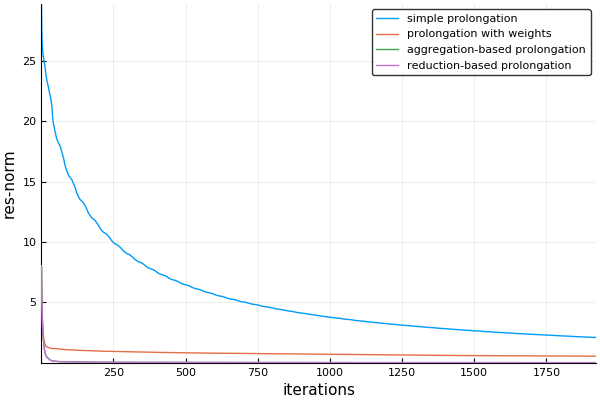

In [31]:
A = getA()
n = size(A,1)
b = ones(Float64, n,1)
# solve
@time x1, history1 = solve(A, b, prolongation1(n))
@time x2, history2 = solve(A, b, prolongation2(n))
@time x3, history3 = solve(A, b, prolongationAggregation(A))
@time x4, history4 = solve(A, b, prolongationReduction(A))

# plot
#gr()
pyplot()
history1data = history1.data[:resnorm]
history2data = history2.data[:resnorm]
history3data = history3.data[:resnorm]
history4data = history4.data[:resnorm]

plot(history1data, xlabel="iterations", ylabel="res-norm", label="simple prolongation")
plot!(history2data, label="prolongation with weights")
plot!(history3data, label="aggregation-based prolongation")
plot!(history4data, label="reduction-based prolongation")
#savefig("prolongations.png")